### What this notebook covers
- Reproducible configuration & logging
- Open data ingestion (OSM via Overpass API)
- Geometry creation & CRS handling (WGS84  projected)
- Data quality checks (schema, nulls, duplicates, geometry validity)
- Spatial EDA (summary stats, distributions, density & clustering signals)
- Export of clean datasets for the next steps (QA/QC and ArcGIS publishing)

In [ ]:
# !pip -q install geopandas shapely pyproj folium matplotlib pandas numpy requests tqdm duckdb

In [1]:
import os
import json
import time
import math
import textwrap
import warnings
from dataclasses import dataclass
from typing import Dict, Any, Optional, List, Tuple

import numpy as np
import pandas as pd
import requests
from tqdm.auto import tqdm

import geopandas as gpd
from shapely.geometry import Point
from shapely.validation import make_valid

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)


In [2]:
@dataclass
class Config:
    # Choose a city/area as a bounding box.
    # Example: Kyiv central bb
    bbox: Tuple[float, float, float, float] = (30.38, 50.40, 30.62, 50.52)

    # OSM Overpass settings
    overpass_url: str = "https://overpass-api.de/api/interpreter"
    overpass_timeout_sec: int = 60

    # What we ingest
    osm_amenities: Tuple[str, ...] = ("hospital", "school", "fuel", "pharmacy", "police", "fire_station")

    # EDA settings
    target_crs_projected: str = "EPSG:3857"
    random_seed: int = 42

    # Outputs
    out_dir: str = "data/01_raw"
    out_clean_dir: str = "data/01_clean"
    out_file_raw: str = "osm_amenities_raw.parquet"
    out_file_clean: str = "osm_amenities_clean.parquet"

cfg = Config()

os.makedirs(cfg.out_dir, exist_ok=True)
os.makedirs(cfg.out_clean_dir, exist_ok=True)

np.random.seed(cfg.random_seed)

def log(msg: str):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}")

log("Config loaded.")
cfg


[12:26:38] Config loaded.


Config(bbox=(30.38, 50.4, 30.62, 50.52), overpass_url='https://overpass-api.de/api/interpreter', overpass_timeout_sec=60, osm_amenities=('hospital', 'school', 'fuel', 'pharmacy', 'police', 'fire_station'), target_crs_projected='EPSG:3857', random_seed=42, out_dir='data/01_raw', out_clean_dir='data/01_clean', out_file_raw='osm_amenities_raw.parquet', out_file_clean='osm_amenities_clean.parquet')

In [3]:
def build_overpass_query(bbox: Tuple[float, float, float, float], amenities: Tuple[str, ...]) -> str:
    """
    Build an Overpass QL query to fetch nodes and ways with given amenity tags within bbox.
    bbox format: (min_lon, min_lat, max_lon, max_lat)
    Overpass uses: (south, west, north, east) => (min_lat, min_lon, max_lat, max_lon)
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    south, west, north, east = min_lat, min_lon, max_lat, max_lon

    amenity_filter = "|".join(amenities)

    query = f"""
    [out:json][timeout:{cfg.overpass_timeout_sec}];
    (
      node["amenity"~"^({amenity_filter})$"]({south},{west},{north},{east});
      way["amenity"~"^({amenity_filter})$"]({south},{west},{north},{east});
      relation["amenity"~"^({amenity_filter})$"]({south},{west},{north},{east});
    );
    out center tags;
    """
    return query.strip()

query = build_overpass_query(cfg.bbox, cfg.osm_amenities)
print(query[:600] + "\n...\n" + query[-150:])


[out:json][timeout:60];
    (
      node["amenity"~"^(hospital|school|fuel|pharmacy|police|fire_station)$"](50.4,30.38,50.52,30.62);
      way["amenity"~"^(hospital|school|fuel|pharmacy|police|fire_station)$"](50.4,30.38,50.52,30.62);
      relation["amenity"~"^(hospital|school|fuel|pharmacy|police|fire_station)$"](50.4,30.38,50.52,30.62);
    );
    out center tags;
...
8,50.52,30.62);
      relation["amenity"~"^(hospital|school|fuel|pharmacy|police|fire_station)$"](50.4,30.38,50.52,30.62);
    );
    out center tags;


In [4]:
def fetch_overpass(query: str, url: str) -> Dict[str, Any]:
    log("Requesting data from Overpass API...")
    r = requests.post(url, data={"data": query}, timeout=120)
    r.raise_for_status()
    return r.json()

data = fetch_overpass(query, cfg.overpass_url)
log(f"Received keys: {list(data.keys())}")
log(f"Number of elements: {len(data.get('elements', []))}")


[12:27:02] Requesting data from Overpass API...
[12:27:04] Received keys: ['version', 'generator', 'osm3s', 'elements']
[12:27:04] Number of elements: 1797


In [5]:
def element_to_record(el: Dict[str, Any]) -> Dict[str, Any]:
    tags = el.get("tags", {}) or {}

    # Geometry extraction:
    # - node has 'lat','lon'
    # - way/relation may have 'center': {'lat','lon'}
    lat = el.get("lat") or (el.get("center") or {}).get("lat")
    lon = el.get("lon") or (el.get("center") or {}).get("lon")

    rec = {
        "osm_type": el.get("type"),
        "osm_id": el.get("id"),
        "lat": lat,
        "lon": lon,
        "amenity": tags.get("amenity"),
        "name": tags.get("name"),
        "operator": tags.get("operator"),
        "brand": tags.get("brand"),
        "addr_city": tags.get("addr:city"),
        "addr_street": tags.get("addr:street"),
        "addr_housenumber": tags.get("addr:housenumber"),
        "addr_postcode": tags.get("addr:postcode"),
        "website": tags.get("website"),
        "phone": tags.get("phone"),
        "raw_tags": json.dumps(tags, ensure_ascii=False),
    }
    return rec

elements = data.get("elements", [])
records = [element_to_record(el) for el in elements]
df = pd.DataFrame(records)
df.head()


,osm_type,osm_id,lat,lon,amenity,name,operator,brand,addr_city,addr_street,addr_housenumber,addr_postcode,website,phone,raw_tags
0,node,256556221,50.499627,30.503510,pharmacy,None,None,None,None,Йорданська вулиця,17-А,04211,www.falbi.ua,None,"{""addr:housenumber"": ""17-А"", ""addr:postcode"": ..."
1,node,256669242,50.504039,30.424838,fuel,БРСМ,БРСМ-Нафта,БРСМ-Нафта,None,проспект Європейського Союзу,39-А,None,None,None,"{""addr:housenumber"": ""39-А"", ""addr:street"": ""п..."
2,node,266715615,50.493282,30.510831,pharmacy,None,None,None,None,None,None,None,None,None,"{""amenity"": ""pharmacy"", ""healthcare"": ""pharmacy""}"
3,node,266893320,50.488297,30.503756,fuel,AMIC Energy,None,Amic,None,None,None,None,None,None,"{""amenity"": ""fuel"", ""brand"": ""Amic"", ""brand:wi..."
4,node,266893321,50.487770,30.509108,fuel,Grand Petrol,УкрАВТО,None,None,None,None,None,None,None,"{""amenity"": ""fuel"", ""name"": ""Grand Petrol"", ""n..."


In [6]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"], crs="EPSG:4326"),
)

log(f"GeoDataFrame shape: {gdf.shape}")
gdf.crs


[12:27:29] GeoDataFrame shape: (1797, 16)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
log("Basic integrity checks...")

# Key fields
assert "osm_id" in gdf.columns
assert gdf["osm_id"].notna().all(), "osm_id contains nulls"

# Duplicates by (type,id)
dup_mask = gdf.duplicated(subset=["osm_type", "osm_id"], keep=False)
n_dups = int(dup_mask.sum())
log(f"Duplicate (osm_type, osm_id): {n_dups}")

# Missing coordinates
n_missing_coords = int(gdf["lat"].isna().sum() + gdf["lon"].isna().sum())
log(f"Missing coords (lat/lon null count total): {n_missing_coords}")

# Amenity distribution
gdf["amenity"].value_counts(dropna=False).head(20)


[12:27:38] Basic integrity checks...
[12:27:38] Duplicate (osm_type, osm_id): 0
[12:27:38] Missing coords (lat/lon null count total): 0


,count
amenity,
pharmacy,1030
school,383
fuel,193
hospital,97
police,68
fire_station,26


In [8]:
missing = (gdf.isna().mean() * 100).sort_values(ascending=False)
missing.head(15)

,0
addr_city,99.888703
addr_postcode,92.988314
phone,86.254869
operator,83.528102
website,79.577073
addr_housenumber,73.121870
brand,72.787980
addr_street,71.730662
name,11.185309
amenity,0.000000


In [9]:
# Points from coords should be valid; still check
invalid_geom = ~gdf.geometry.is_valid
log(f"Invalid geometries: {int(invalid_geom.sum())}")


if invalid_geom.any():
    gdf.loc[invalid_geom, "geometry"] = gdf.loc[invalid_geom, "geometry"].apply(make_valid)
    log("Invalid geometries were fixed with make_valid().")

[12:28:04] Invalid geometries: 0


In [10]:
def clean_text(x: Optional[str]) -> Optional[str]:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    x = str(x).strip()
    x = " ".join(x.split())
    return x if x else None

text_cols = ["name", "operator", "brand", "addr_city", "addr_street", "addr_housenumber", "addr_postcode", "website", "phone"]
for c in text_cols:
    gdf[c] = gdf[c].apply(clean_text)

def build_full_address(row) -> Optional[str]:
    parts = [
        row.get("addr_city"),
        row.get("addr_street"),
        row.get("addr_housenumber"),
        row.get("addr_postcode"),
    ]
    parts = [p for p in parts if p]
    return ", ".join(parts) if parts else None

gdf["full_address"] = gdf.apply(build_full_address, axis=1)
gdf[["amenity", "name", "full_address"]].head(10)

,amenity,name,full_address
0,pharmacy,None,"Йорданська вулиця, 17-А, 04211"
1,fuel,БРСМ,"проспект Європейського Союзу, 39-А"
2,pharmacy,None,None
3,fuel,AMIC Energy,None
4,fuel,Grand Petrol,None
5,pharmacy,Biokon,None
6,pharmacy,Мирова,None
7,pharmacy,Аптека TAS,None
8,fuel,Shell,None
9,pharmacy,Пані Аптека,None


In [11]:
gdf_proj = gdf.to_crs(cfg.target_crs_projected)
gdf_proj.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
log("High-level EDA summary:")

summary = pd.DataFrame({
    "n_rows": [len(gdf_proj)],
    "n_unique_objects": [gdf_proj.drop_duplicates(["osm_type", "osm_id"]).shape[0]],
    "n_named": [gdf_proj["name"].notna().sum()],
    "n_with_address": [gdf_proj["full_address"].notna().sum()],
    "amenity_types": [gdf_proj["amenity"].nunique(dropna=True)],
})

summary

[12:28:40] High-level EDA summary:


,n_rows,n_unique_objects,n_named,n_with_address,amenity_types
0,1797,1797,1596,512,6


In [13]:
amenity_counts = gdf_proj["amenity"].value_counts().reset_index()
amenity_counts.columns = ["amenity", "count"]
amenity_counts

,amenity,count
0,pharmacy,1030
1,school,383
2,fuel,193
3,hospital,97
4,police,68
5,fire_station,26


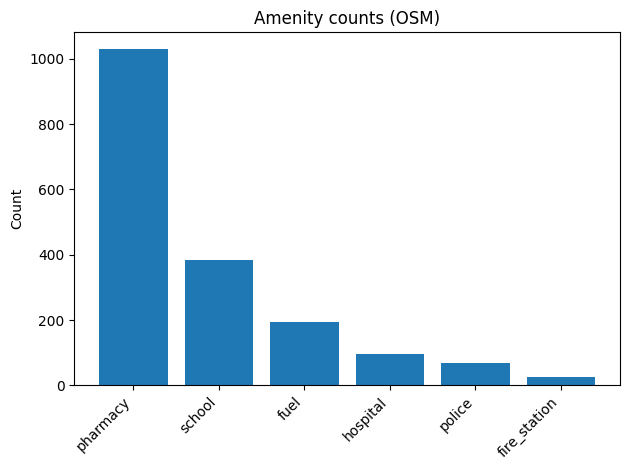

In [14]:
plt.figure()
plt.bar(amenity_counts["amenity"], amenity_counts["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Amenity counts (OSM)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [15]:
import folium

# Center of bbox
min_lon, min_lat, max_lon, max_lat = cfg.bbox
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

# Color per amenity
palette = {
    "hospital": "red",
    "school": "blue",
    "fuel": "green",
    "pharmacy": "purple",
    "police": "black",
    "fire_station": "orange"
}

sample = gdf.sample(min(2000, len(gdf)), random_state=cfg.random_seed)  # avoid huge map
for _, r in sample.iterrows():
    color = palette.get(r["amenity"], "gray")
    tooltip = f"{r['amenity']} | {r.get('name') or ''}".strip()
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=tooltip
    ).add_to(m)

m

In [16]:
from sklearn.neighbors import NearestNeighbors

coords = np.vstack([gdf_proj.geometry.x.values, gdf_proj.geometry.y.values]).T
if len(coords) >= 5:
    nn = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(coords)
    dists, idxs = nn.kneighbors(coords)
    # dists[:,0] = 0 (self), dists[:,1] = nearest neighbor
    gdf_proj["nn_dist_m"] = dists[:, 1]
    gdf_proj["nn_dist_m"].describe(percentiles=[0.1, 0.5, 0.9])
else:
    log("Not enough points for NN analysis.")

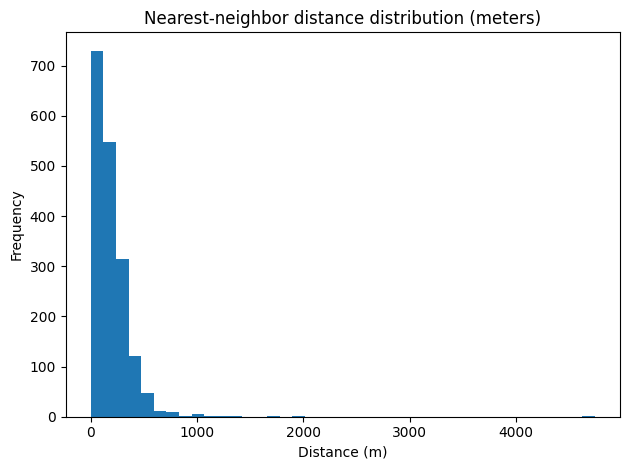

In [17]:
plt.figure()
plt.hist(gdf_proj["nn_dist_m"].dropna(), bins=40)
plt.title("Nearest-neighbor distance distribution (meters)")
plt.xlabel("Distance (m)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [18]:
eda_by_amenity = (
    gdf_proj
    .groupby("amenity")
    .agg(
        count=("osm_id", "count"),
        named=("name", lambda s: s.notna().sum()),
        with_address=("full_address", lambda s: s.notna().sum()),
        median_nn_m=("nn_dist_m", "median"),
        p90_nn_m=("nn_dist_m", lambda s: np.nanpercentile(s, 90)),
    )
    .sort_values("count", ascending=False)
)

eda_by_amenity

,count,named,with_address,median_nn_m,p90_nn_m
amenity,,,,,
pharmacy,1030,915,203,111.795085,297.684328
school,383,346,117,223.594753,404.217629
fuel,193,175,89,269.794455,587.309587
hospital,97,94,62,158.511867,368.027553
police,68,51,30,165.349864,381.812555
fire_station,26,15,11,160.116833,501.794694


In [19]:
raw_path = os.path.join(cfg.out_dir, cfg.out_file_raw)
gdf.to_parquet(raw_path, index=False)
log(f"Saved RAW parquet: {raw_path}")

[12:30:08] Saved RAW parquet: data/01_raw/osm_amenities_raw.parquet


In [20]:
# Deduplicate by primary key
gdf_clean = gdf_proj.drop_duplicates(subset=["osm_type", "osm_id"]).copy()

# Remove rows with missing coordinates
gdf_clean = gdf_clean[gdf_clean.geometry.notna()].copy()

# Keep a curated set of columns for downstream pipeline
keep_cols = [
    "osm_type", "osm_id", "amenity", "name", "operator", "brand",
    "addr_city", "addr_street", "addr_housenumber", "addr_postcode",
    "full_address", "website", "phone",
    "lat", "lon", "nn_dist_m",
    "raw_tags", "geometry"
]
keep_cols = [c for c in keep_cols if c in gdf_clean.columns]
gdf_clean = gdf_clean[keep_cols].copy()

clean_path = os.path.join(cfg.out_clean_dir, cfg.out_file_clean)
gdf_clean.to_parquet(clean_path, index=False)
log(f"Saved CLEAN parquet: {clean_path}")

gdf_clean.head()

[12:30:25] Saved CLEAN parquet: data/01_clean/osm_amenities_clean.parquet


,osm_type,osm_id,amenity,name,operator,brand,addr_city,addr_street,addr_housenumber,addr_postcode,full_address,website,phone,lat,lon,nn_dist_m,raw_tags,geometry
0,node,256556221,pharmacy,None,None,None,None,Йорданська вулиця,17-А,04211,"Йорданська вулиця, 17-А, 04211",www.falbi.ua,None,50.499627,30.503510,160.376924,"{""addr:housenumber"": ""17-А"", ""addr:postcode"": ...",POINT (3395635.201 6533256.325)
1,node,256669242,fuel,БРСМ,БРСМ-Нафта,БРСМ-Нафта,None,проспект Європейського Союзу,39-А,None,"проспект Європейського Союзу, 39-А",None,None,50.504039,30.424838,192.799021,"{""addr:housenumber"": ""39-А"", ""addr:street"": ""п...",POINT (3386877.507 6534028.425)
2,node,266715615,pharmacy,None,None,None,None,None,None,None,None,None,None,50.493282,30.510831,262.456815,"{""amenity"": ""pharmacy"", ""healthcare"": ""pharmacy""}",POINT (3396450.137 6532145.958)
3,node,266893320,fuel,AMIC Energy,None,Amic,None,None,None,None,None,None,None,50.488297,30.503756,201.119147,"{""amenity"": ""fuel"", ""brand"": ""Amic"", ""brand:wi...",POINT (3395662.541 6531273.69)
4,node,266893321,fuel,Grand Petrol,УкрАВТО,None,None,None,None,None,None,None,None,50.487770,30.509108,442.075709,"{""amenity"": ""fuel"", ""name"": ""Grand Petrol"", ""n...",POINT (3396258.345 6531181.536)


In [21]:
report = {
    "area_bbox": cfg.bbox,
    "n_elements_downloaded": int(len(gdf)),
    "n_clean_records": int(len(gdf_clean)),
    "amenities": gdf_clean["amenity"].value_counts().to_dict(),
    "named_ratio": float(gdf_clean["name"].notna().mean()),
    "address_ratio": float(gdf_clean["full_address"].notna().mean()),
    "nn_dist_median": float(np.nanmedian(gdf_clean["nn_dist_m"])) if "nn_dist_m" in gdf_clean else None,
}
report

{'area_bbox': (30.38, 50.4, 30.62, 50.52),
 'n_elements_downloaded': 1797,
 'n_clean_records': 1797,
 'amenities': {'pharmacy': 1030,
  'school': 383,
  'fuel': 193,
  'hospital': 97,
  'police': 68,
  'fire_station': 26},
 'named_ratio': 0.8881469115191987,
 'address_ratio': 0.2849193099610462,
 'nn_dist_median': 154.26613775434257}

In [22]:
md = f"""
### Ingest & EDA Summary

- **BBox:** `{report['area_bbox']}`
- **Downloaded OSM elements:** `{report['n_elements_downloaded']}`
- **Clean records:** `{report['n_clean_records']}`
- **Named ratio:** `{report['named_ratio']:.2%}`
- **Address ratio:** `{report['address_ratio']:.2%}`
- **Median NN distance (m):** `{report['nn_dist_median']:.1f}`

**Amenity distribution:**
{json.dumps(report['amenities'], indent=2, ensure_ascii=False)}
"""
print(md)


### Ingest & EDA Summary

- **BBox:** `(30.38, 50.4, 30.62, 50.52)`
- **Downloaded OSM elements:** `1797`
- **Clean records:** `1797`
- **Named ratio:** `88.81%`
- **Address ratio:** `28.49%`
- **Median NN distance (m):** `154.3`

**Amenity distribution:**
{
  "pharmacy": 1030,
  "school": 383,
  "fuel": 193,
  "hospital": 97,
  "police": 68,
  "fire_station": 26
}

